# Estimation of tree height using GEDI dataset - Perceptron

Python packages intallation

    pip3 install torch
    
Ref: https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Single-layer perceptron takes data as input and its weights are summed up then an activation function is applied before sent to the output layer. Here is an example for a data with 3 features (ie, predictors):

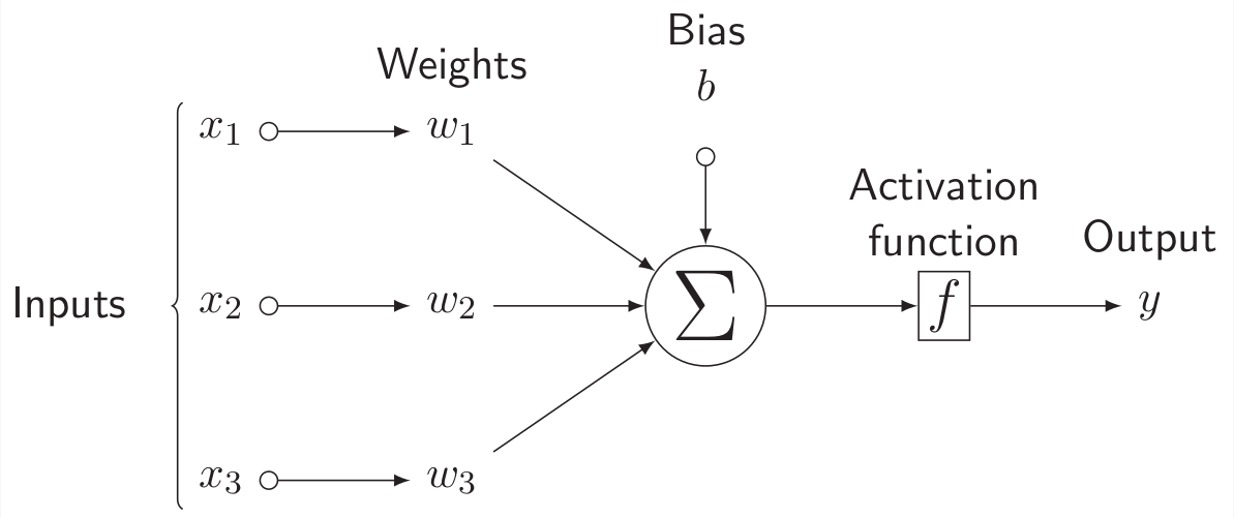

In [4]:
from IPython.display import Image
Image("../images/perceptron.jpeg" , width = 600, height = 300)

The use of an activation function depends on the expected output range or ditribution, which we will discuss in more details later. There are several options for activation function. To learn more about activation functions, checkout this great [blogpost](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/). 

<span style="color:red">**Question 1**</span>: what is the difference between the Perceptron shown above an a simple linear regression? 

Now let's see how we can implement a Perceptron:

In [14]:
class Perceptron(torch.nn.Module):
    def __init__(self,input_size, output_size, use_activation_fn=False):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size,output_size) # Initializes weights with uniform distribution centered in zero
        self.activation_fn = nn.ReLU() # instead of Heaviside step fn
        self.use_activation_fn = use_activation_fn # If we want to use an activation function
    def forward(self, x):
        output = self.fc(x)
        if self.use_activation_fn:
            output = self.activation_fn(output) # To add the non-linearity. Try training you Perceptron with and without the non-linearity
        return output

The building blocks of the Perceptron code:
- nn.Linear: Applies a linear transformation to the incoming data: y = xA^T + b
- nn.ReLU: Applies the rectified linear unit function element-wise

Before we try to solve a real-world problem let's see how it works on a simpler data. For data, I will create a simple 2D regression problem.

Text(0.5, 1.0, 'Test data')

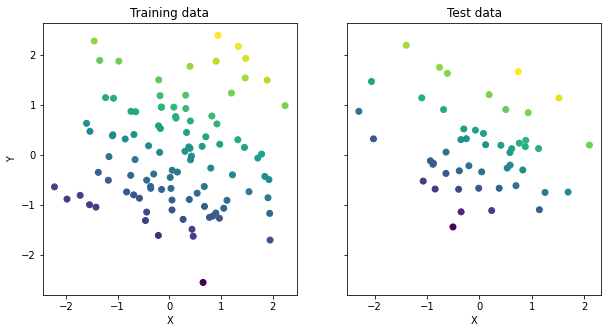

In [3]:
# CREATE RANDOM DATA POINTS
# from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression

x_train, y_train = make_regression(n_samples=100, n_features=2, random_state=0) 
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

x_test, y_test = make_regression(n_samples=50, n_features=2, random_state=1) 
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)


#Visualize the data
fig,ax=plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].scatter(x_train[:,0],x_train[:,1],c=y_train)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Training data')

ax[1].scatter(x_test[:,0],x_test[:,1],c=y_test)
ax[1].set_xlabel('X')
ax[1].set_title('Test data')

Let's have a quick look at the distributions:

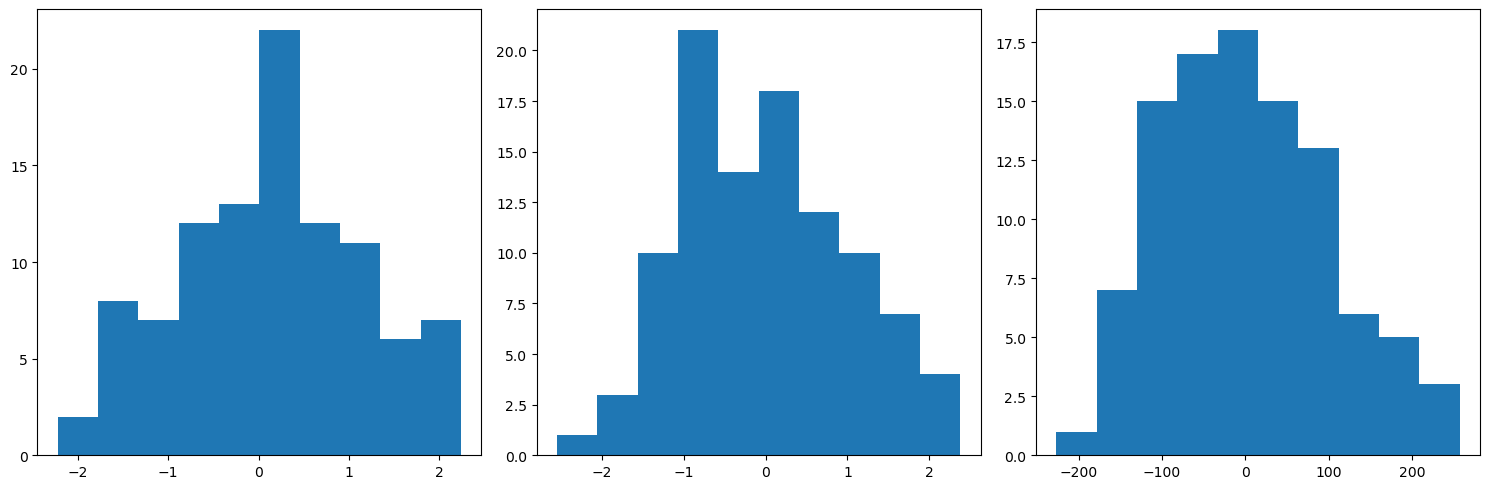

In [12]:
data_train = np.concatenate([x_train, y_train[:,None]],axis=1)
n_plots_x = int(np.ceil(np.sqrt(data_train.shape[1])))
n_plots_y = int(np.floor(np.sqrt(data_train.shape[1])))
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(data_train.shape[1]):
    ax[idx].hist(data_train[:,idx].flatten())
fig.tight_layout()

Now let's initialize our Perceptron model, define the type of optimizer and loss we want to use:

In [4]:
model = Perceptron(input_size=2, output_size=1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

Just for curiosity, let's se how bad a naive model would perform in this task

x_test.shape:  torch.Size([50, 2])
y_pred.shape:  torch.Size([50, 1])
y_test.shape:  torch.Size([50])
Test loss before training 4663.203125


Text(0.5, 1.0, 'slope: -148.420, r_value: -0.790')

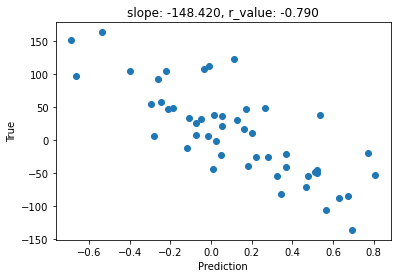

In [5]:
model.eval()
y_pred = model(x_test)
print('x_test.shape: ',x_test.shape)
print('y_pred.shape: ',y_pred.shape)
print('y_test.shape: ',y_test.shape)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training' , before_train.item())

y_pred = y_pred.detach().numpy().squeeze()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

# # Fit line
# x = np.arange(-150,150)

fig,ax=plt.subplots()
ax.scatter(y_pred, y_test)
# ax.plot(x, intercept + slope*x, 'r', label='fitted line')
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.3f}, r_value: {:.3f}'.format(slope, r_value))

<span style="color:red">**Question 1.1**</span>: Can you make sense of this model's output range? 

Now let's train our Perceptron to model this data

In [6]:
model.train()
epoch = 1000
all_loss=[]
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    # Backward pass
    loss.backward()
    optimizer.step()
    
    all_loss.append(loss.item())

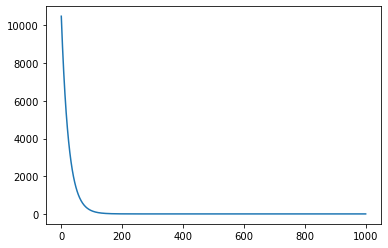

In [7]:
fig,ax=plt.subplots()
ax.plot(all_loss)

Test loss after Training 298.5340576171875


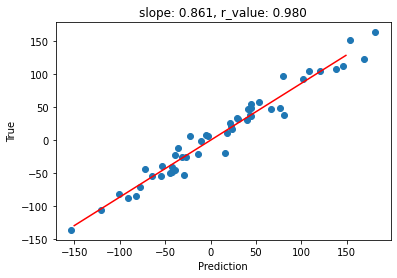

In [8]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    after_train = criterion(y_pred.squeeze(), y_test) 
    print('Test loss after Training' , after_train.item())

    y_pred = y_pred.detach().numpy().squeeze()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

    # Fit line
    x = np.arange(-150,150)

    fig,ax=plt.subplots()
    ax.scatter(y_pred, y_test)
    ax.plot(x, intercept + slope*x, 'r', label='fitted line')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True')
    ax.set_title('slope: {:.3f}, r_value: {:.3f}'.format(slope, r_value))

This results is not bad, but note that we didn't use any activation function. Now let's see what happens when we add an activation

Test loss after Training 1798.1923828125


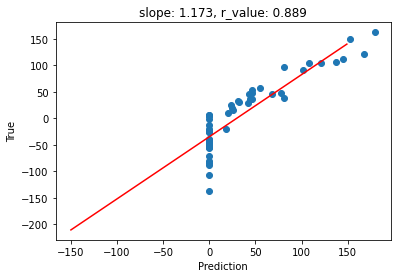

In [10]:
# Add activation and retrain the model 
del model, optimizer
model = Perceptron(input_size=2, output_size=1, use_activation_fn=True)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

model.train()
epoch = 1000
all_loss=[]
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    # Backward pass
    loss.backward()
    optimizer.step()
    
    all_loss.append(loss.item())

model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    after_train = criterion(y_pred.squeeze(), y_test) 
    print('Test loss after Training' , after_train.item())

    y_pred = y_pred.detach().numpy().squeeze()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

    # Fit line
    x = np.arange(-150,150)

    fig,ax=plt.subplots()
    ax.scatter(y_pred, y_test)
    ax.plot(x, intercept + slope*x, 'r', label='fitted line')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True')
    ax.set_title('slope: {:.3f}, r_value: {:.3f}'.format(slope, r_value))

<span style="color:red">**Question 2**</span>: what is happenng to this model? Why do we have so many predicted outputs with 'zeros'?

Let's see what happens when the data and target are normalized

In [10]:
#Now normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data_train = np.concatenate([x_train, y_train[:,None]],axis=1)
data_train = scaler.fit_transform(data_train)
data_test = np.concatenate([x_test, y_test[:,None]],axis=1)
data_test = scaler.transform(data_test)

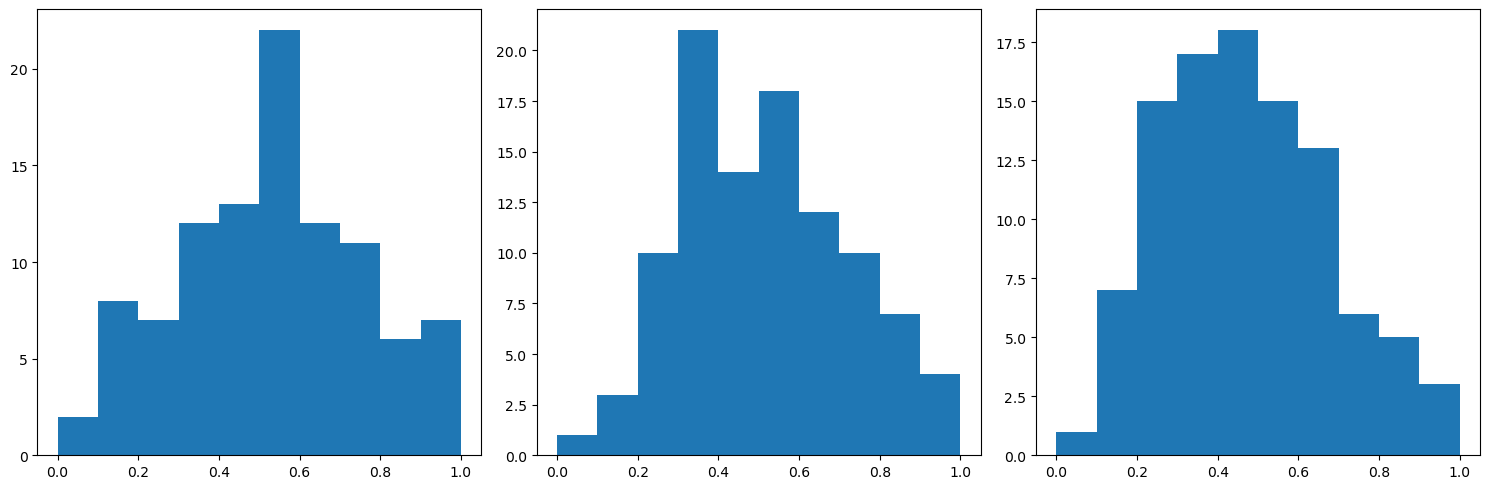

In [11]:
n_plots_x = int(np.ceil(np.sqrt(data_train.shape[1])))
n_plots_y = int(np.floor(np.sqrt(data_train.shape[1])))
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(data_train.shape[1]):
    ax[idx].hist(data_train[:,idx].flatten())
fig.tight_layout()

In [12]:
x_train,y_train = data_train[:,:2],data_train[:,2]
x_test,y_test = data_test[:,:2],data_test[:,2]

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

In [14]:
del model, optimizer
model = Perceptron(input_size=2, output_size=1, use_activation_fn=True)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [15]:
model.train()
epoch = 1000
all_loss=[]
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    # Backward pass
    loss.backward()
    optimizer.step()
    
    all_loss.append(loss.item())

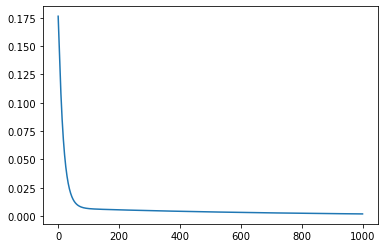

In [16]:
fig,ax=plt.subplots()
ax.plot(all_loss)

Test loss after Training 0.0008271266706287861
0.18696567 0.80532324


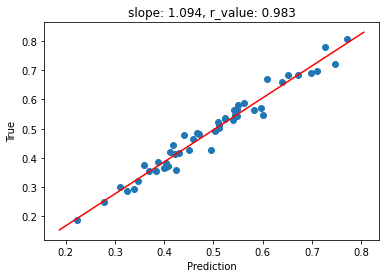

In [17]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    after_train = criterion(y_pred.squeeze(), y_test) 
    print('Test loss after Training' , after_train.item())

    y_pred = y_pred.detach().numpy().squeeze()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

    # Fit line
    print(y_test.numpy().min(),y_test.numpy().max())
    x = np.linspace(y_test.numpy().min(),y_test.numpy().max(),len(y_test))

    fig,ax=plt.subplots()
    ax.scatter(y_pred, y_test)
    ax.plot(x, intercept + slope*x, 'r', label='fitted line')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True')
    ax.set_title('slope: {:.3f}, r_value: {:.3f}'.format(slope, r_value))

Now that we know how to implement a Perceptron and how it works on a toy data, let's see a more interesting dataset. For that, we will use the tree height dataset. For simplicity, let's start with just few variables: latitude (x) and longitude (y).

In [4]:
### Try the the tree height with Perceptron 
# data = pd.read_csv('./tree_height/txt/eu_x_y_height_predictors.txt',  sep=" ")
data = pd.read_csv('./tree_height/txt/eu_x_y_height.txt',  sep=" ")
print(data.shape)
print(data.head())

(66522, 3)
          x          y      h
0  6.894317  49.482459   2.73
1  7.023274  49.510552  10.75
2  7.394650  49.590488  21.20
3  7.396895  49.590968  20.00
4  7.397643  49.591128  24.23


In [5]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

(array([5.287e+03, 2.447e+03, 1.626e+03, 1.406e+03, 1.308e+03, 1.327e+03,
        1.483e+03, 1.721e+03, 1.957e+03, 2.022e+03, 2.131e+03, 2.314e+03,
        2.726e+03, 3.055e+03, 3.551e+03, 3.900e+03, 3.956e+03, 4.169e+03,
        4.049e+03, 3.536e+03, 3.120e+03, 2.561e+03, 1.923e+03, 1.473e+03,
        1.069e+03, 7.340e+02, 5.460e+02, 3.720e+02, 2.410e+02, 1.860e+02,
        1.010e+02, 7.200e+01, 7.300e+01, 4.300e+01, 1.500e+01, 6.000e+00,
        6.000e+00, 6.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 

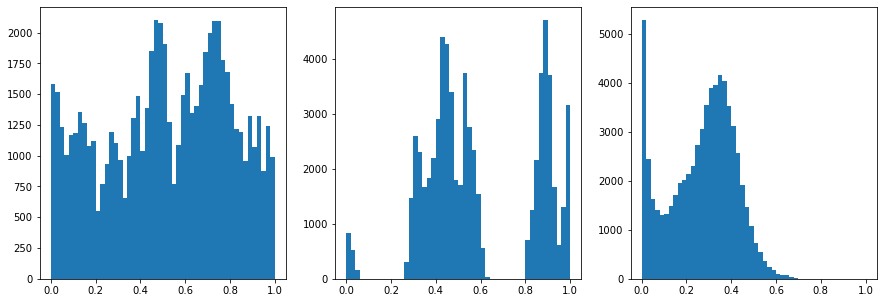

In [6]:
#Inspect the ranges 
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(data[:,0],50)
ax[1].hist(data[:,1],50)
ax[2].hist(data[:,2],50)

In [7]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(data[:,:2], data[:,2], test_size=0.30, random_state=0)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train.shape: torch.Size([46565, 2]), X_test.shape: torch.Size([19957, 2]), y_train.shape: torch.Size([46565]), y_test.shape: torch.Size([19957])


In [8]:
# Create percetron
model = Perceptron(input_size=2, output_size=1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [9]:
model.train()
epoch = 5000
all_loss=[]
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    # Backward pass
    loss.backward()
    optimizer.step()
    
    all_loss.append(loss.item())

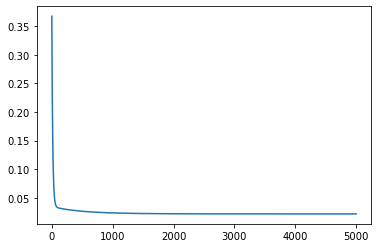

In [10]:
fig,ax=plt.subplots()
ax.plot(all_loss)

Test loss after Training 0.021578431129455566


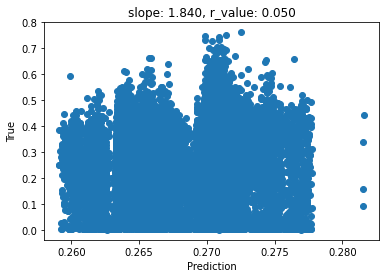

In [11]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    after_train = criterion(y_pred.squeeze(), y_test) 
    print('Test loss after Training' , after_train.item())

    y_pred = y_pred.detach().numpy().squeeze()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

    fig,ax=plt.subplots()
    ax.scatter(y_pred, y_test)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True')
    ax.set_title('slope: {:.3f}, r_value: {:.3f}'.format(slope, r_value))

<span style="color:red">**Question 3**</span>: As we can see, the Perceptron didn't perform well with the setup described above. Based on what we have discussed so far, what is wrong with our setup (model and data) and how can we make it better? 